In [2]:
import os
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
data_dir='Dataset'

In [4]:
# i have taken the random address from each dataset

image_braintumor = Image.open("/home/shahzaib/ANNProject/Dataset/brain tumor/Brain Tumor 'Meningioma'/Te-me_0023.jpg")
image_chestxay = Image.open("/home/shahzaib/ANNProject/Dataset/chest_xray/PNEUMONIA in XRAY/person1_virus_11.jpeg")
image_lungcancer = Image.open("/home/shahzaib/ANNProject/Dataset/lungscancer/Lung Cancer 'Squamous cell carcinoma'/000010 (6).png")  

print(f"Number of channels in Brain Tumor Dataset is : {len(image_braintumor.getbands())} and the mode: {image_braintumor.mode}")
print(f"Number of channels in ChestXrays Dataset is : {len(image_chestxay.getbands())} and the mode: {image_chestxay.mode}")
print(f"Number of channels in Lung Cancer Dataset is : {len(image_lungcancer.getbands())} and the mode: {image_lungcancer.mode}")

Number of channels in Brain Tumor Dataset is : 3 and the mode: RGB
Number of channels in ChestXrays Dataset is : 1 and the mode: L
Number of channels in Lung Cancer Dataset is : 4 and the mode: RGBA


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode == 'RGBA' else x.convert('RGB')),  # converted rgba and l grayscale into rgb
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [10]:
def load_multiple_datasets(data_dir):
    file_paths = []
    labels = []
    class_to_idx = {}

   
    for dataset_name in os.listdir(data_dir):
        dataset_path = os.path.join(data_dir, dataset_name)
        if not os.path.isdir(dataset_path):  
            continue

        for class_name in os.listdir(dataset_path):
            class_dir = os.path.join(dataset_path, class_name)
            if not os.path.isdir(class_dir): 
                continue

            class_idx = len(class_to_idx)
            class_to_idx[class_name] = class_idx  

            for filename in os.listdir(class_dir):
                if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                    file_paths.append(os.path.join(class_dir, filename))
                    labels.append(class_idx)

    print(f"Loaded {len(file_paths)} images from {len(class_to_idx)} classes.")
    return file_paths, labels, class_to_idx

file_paths, labels, class_to_idx = load_multiple_datasets(data_dir)

if len(file_paths) == 0:
    raise ValueError(f"No image files found in the dataset directory: {data_dir}")

labels = torch.tensor(labels)
 



Loaded 13779 images from 10 classes.


In [11]:
class_to_idx

{"Lung Cancer 'Large Cell carcinoma'": 0,
 'No Lung Cancer in this CT Scan': 1,
 "Lung Cancer 'Adenocarcin oma'": 2,
 "Lung Cancer 'Squamous cell carcinoma'": 3,
 "Brain Tumor 'Glioma'": 4,
 "Brain Tumor 'Pituitary'": 5,
 "Brain Tumor 'Meningioma'": 6,
 'No Brain Tumor in MRI': 7,
 'PNEUMONIA in XRAY': 8,
 'Normal XRAY No Pneumonia': 9}

In [23]:
train_files, temp_files, train_labels, temp_labels = train_test_split(file_paths, labels, test_size=0.3, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)


In [24]:
train_dataset = CustomImageDataset(train_files, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_files, val_labels, transform=transform)
test_dataset = CustomImageDataset(test_files, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

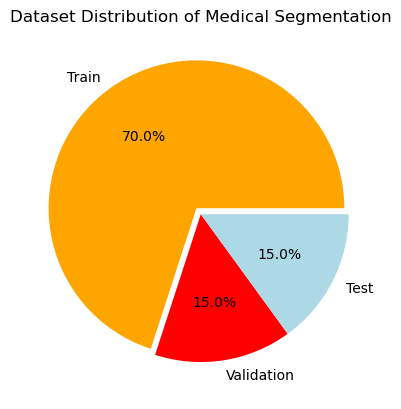

In [25]:

plt.pie([len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)],
        labels=['Train', 'Validation', 'Test'],
        autopct='%.1f%%',
        colors=['orange', 'red', 'lightblue'],
        explode=(0.05, 0, 0)) 
plt.title('Dataset Distribution of Medical Segmentation')
plt.show()

In [26]:

for images, labels in train_loader:
    print("Images batch shape:", images.shape)  # This should print (batch_size, 3, 224, 224)
    
    print("Labels batch shape:", labels.shape)  # This should print (batch_size,)
   
    print("Labels sample:", labels[:5])  # Show first 5 labels
    break  # Only process one batch for this test


Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Labels sample: tensor([7, 7, 4, 7, 7])


Image 1: Mode = RGB, Shape = (224, 224) (Width x Height), Channels = ('R', 'G', 'B')
tensor(5)


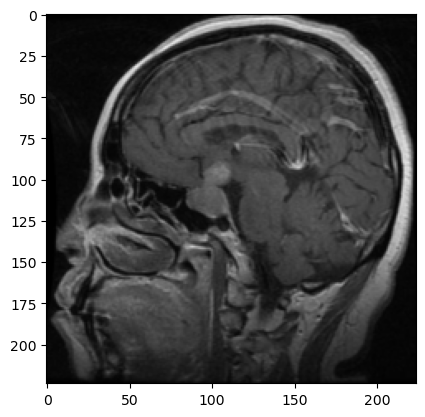

Image 2: Mode = RGB, Shape = (224, 224) (Width x Height), Channels = ('R', 'G', 'B')
tensor(8)


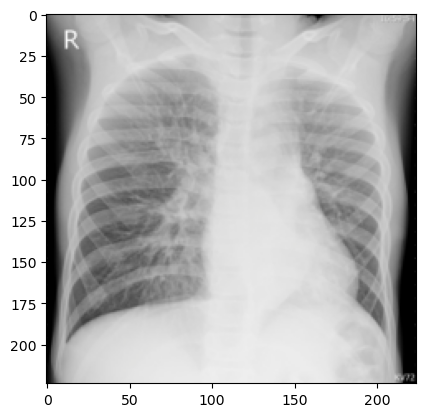

Image 3: Mode = RGB, Shape = (224, 224) (Width x Height), Channels = ('R', 'G', 'B')
tensor(7)


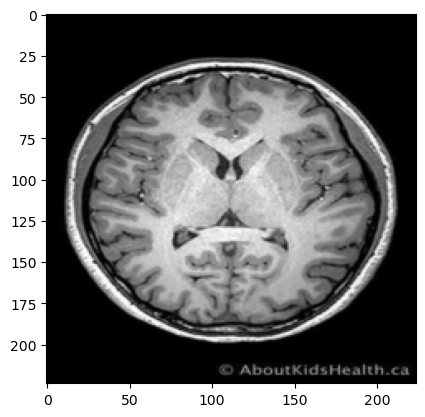

Image 4: Mode = RGB, Shape = (224, 224) (Width x Height), Channels = ('R', 'G', 'B')
tensor(7)


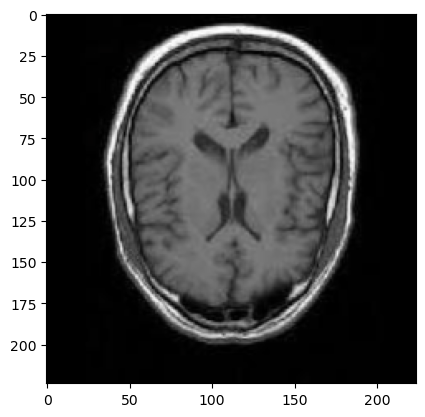

Image 5: Mode = RGB, Shape = (224, 224) (Width x Height), Channels = ('R', 'G', 'B')
tensor(9)


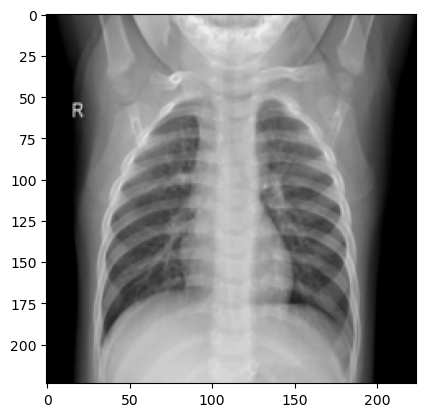

In [27]:
def imshow(tensor, unnormalize=True):
    if unnormalize:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        tensor = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    
    image = tensor.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.show()

# Loop through the first batch
for images, labels in train_loader:
    for i in range(5):
        pil_image = transforms.ToPILImage()(images[i])
        print(f"Image {i+1}: Mode = {pil_image.mode}, Shape = {pil_image.size} (Width x Height), Channels = {pil_image.getbands()}")
        print(labels[i])
        imshow(images[i])
    break  


In [12]:
torch.save({
    'class_to_idx': class_to_idx}, 'dataset_info.pth')                    # saving class to idx labels to use in testing



### CNN

In [29]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 224x224 -> 224x224
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # 224x224 -> 224x224
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # 224x224 -> 224x224
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduces size by half: 224x224 -> 112x112

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Flatten the 112x112x128 output to 512
        self.fc2 = nn.Linear(512, num_classes)  # Output layer, number of classes (e.g., 2 for binary classification)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 224x224 -> 112x112
        x = self.pool(F.relu(self.conv2(x)))  # 112x112 -> 56x56
        x = self.pool(F.relu(self.conv3(x)))  # 56x56 -> 28x28

        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor to a vector

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

model = CNNModel(num_classes=len(class_to_idx))  # i have 10 output classes based on you can see in class_to_idx
print(model)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [30]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [83]:
'''epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as tepoch:
        for images, labels in tepoch:  
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions * 100
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
'''

'epochs = 10\nfor epoch in range(epochs):\n    model.train()\n    running_loss = 0.0\n    correct_predictions = 0\n    total_predictions = 0\n\n    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as tepoch:\n        for images, labels in tepoch:  \n            optimizer.zero_grad()\n            outputs = model(images)\n\n            loss = criterion(outputs, labels)\n\n            loss.backward()\n            optimizer.step()\n\n            running_loss += loss.item()\n            _, predicted = torch.max(outputs, 1)\n            correct_predictions += (predicted == labels).sum().item()\n            total_predictions += labels.size(0)\n\n        epoch_loss = running_loss / len(train_loader)\n        epoch_accuracy = correct_predictions / total_predictions * 100\n        print(f\'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%\')\n'

In [49]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Training)", unit="batch") as tepoch:
        for images, labels in tepoch:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions * 100
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")

    # Validation 
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Validation)", unit="batch") as tepoch:
            for images, labels in tepoch:
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total * 100
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Testing 
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as tepoch:
        for images, labels in tepoch:
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0) 
            print(labels.size)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/10 (Training):   1%|          | 3/302 [00:10<17:05,  3.43s/batch]


KeyboardInterrupt: 

### Save Model LOad_State( the learned paramenter / weights)

In [2]:
torch.save(model.state_dict(), 'model_state_dict_with_32_batchsize.pth')

NameError: name 'torch' is not defined

## Test with custom images

In [103]:
test_folder = '/home/shahzaib/ANNProject/custom test images'  
image_paths = [os.path.join(test_folder, fname) for fname in os.listdir(test_folder) if fname.endswith(('.jpg', '.jpeg', '.png'))]  # Filter for image files

idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse class_to_idx for easier lookup

for image_path in image_paths:
    # Load and transform the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 
    
    # Make the prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)  
    predicted_label = idx_to_class[predicted_class.item()]
    
    print(f"Image: {os.path.basename(image_path)} | Predicted label: {predicted_label}")

Image: brain tumor mein.jpeg | Predicted label: No Brain Tumor in MRI
Image: pneumonia.jpeg | Predicted label: Normal XRAY No Pneumonia
Image: brain tumor melegent.jpg | Predicted label: Brain Tumor 'Meningioma'
Image: largecell carcinoma.jpeg | Predicted label: Lung Cancer 'Squamous cell carcinoma'
Image: normal xray no p.jpeg | Predicted label: PNEUMONIA in XRAY
Image: normal xray.jpeg | Predicted label: Normal XRAY No Pneumonia
Image: normal xray.jpg | Predicted label: PNEUMONIA in XRAY
Image: no tumor.jpg | Predicted label: No Brain Tumor in MRI
Image: P1neumonia xray.jpeg | Predicted label: Normal XRAY No Pneumonia


## with 16 batch size

In [31]:
model_32=CNNModel(num_classes=len(class_to_idx))
model_32.load_state_dict(torch.load("model_state_dict.pth"))


/tmp/ipykernel_5123/2379271567.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_32.load_state_dict(torch.load("model_state_dict.pth"))


<All keys matched successfully>

In [32]:
model_32.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [35]:
test_folder = '/home/shahzaib/ANNProject/custom test images'  
image_paths = [os.path.join(test_folder, fname) for fname in os.listdir(test_folder) if fname.endswith(('.jpg', '.jpeg', '.png'))] 

idx_to_class = {v: k for k, v in class_to_idx.items()}  

for image_path in image_paths:
   
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 
    
    # Make the prediction
    with torch.no_grad():
        outputs = model_32(image)
        _, predicted_class = torch.max(outputs, 1)  
    predicted_label = idx_to_class[predicted_class.item()]
    
    print(f"Image: {os.path.basename(image_path)} | Predicted label: {predicted_label}")

Image: brain tumor mein.jpeg | Predicted label: Brain Tumor 'Meningioma'
Image: CT-CHEST-0002-1024x1012.jpg | Predicted label: Lung Cancer 'Adenocarcin oma'
Image: pneumonia.jpeg | Predicted label: Normal XRAY No Pneumonia
Image: 4c1383482027c97c445f418c9b74b3_big_gallery.jpg | Predicted label: No Lung Cancer in this CT Scan
Image: brain tumor melegent.jpg | Predicted label: Brain Tumor 'Meningioma'
Image: largecell carcinoma.jpeg | Predicted label: Lung Cancer 'Large Cell carcinoma'
Image: Original-Lungs-CT-scan-image.png | Predicted label: Lung Cancer 'Large Cell carcinoma'
Image: normal xray no p.jpeg | Predicted label: Normal XRAY No Pneumonia
Image: normal xray.jpeg | Predicted label: Normal XRAY No Pneumonia
Image: normal xray.jpg | Predicted label: Normal XRAY No Pneumonia
Image: no tumor.jpg | Predicted label: No Brain Tumor in MRI
Image: P1neumonia xray.jpeg | Predicted label: Normal XRAY No Pneumonia


In [53]:

model_32.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    with tqdm(test_loader, desc="Testing", unit="batch") as tepoch:
        for images, labels in tepoch:
            outputs = model_32(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0) 
            print(labels.size())

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total * 100
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Testing:   2%|▏         | 1/65 [00:01<01:39,  1.56s/batch]

<built-in method size of Tensor object at 0x7820eff8dfe0>


Testing:   3%|▎         | 2/65 [00:02<01:28,  1.41s/batch]

<built-in method size of Tensor object at 0x7820f56cd630>


Testing:   5%|▍         | 3/65 [00:04<01:36,  1.55s/batch]

<built-in method size of Tensor object at 0x7820eff8d130>


Testing:   6%|▌         | 4/65 [00:06<01:31,  1.50s/batch]

<built-in method size of Tensor object at 0x7820eff8d590>


Testing:   8%|▊         | 5/65 [00:07<01:30,  1.50s/batch]

<built-in method size of Tensor object at 0x7820f56cc190>


Testing:   9%|▉         | 6/65 [00:09<01:31,  1.55s/batch]

<built-in method size of Tensor object at 0x7820eff8cc30>


Testing:  11%|█         | 7/65 [00:10<01:25,  1.47s/batch]

<built-in method size of Tensor object at 0x7820f56cceb0>


Testing:  12%|█▏        | 8/65 [00:11<01:18,  1.38s/batch]

<built-in method size of Tensor object at 0x7820eff8d3b0>


Testing:  14%|█▍        | 9/65 [00:12<01:15,  1.34s/batch]

<built-in method size of Tensor object at 0x7820eff8dd60>


Testing:  15%|█▌        | 10/65 [00:14<01:11,  1.30s/batch]

<built-in method size of Tensor object at 0x7820f56cd3b0>


Testing:  17%|█▋        | 11/65 [00:15<01:15,  1.39s/batch]

<built-in method size of Tensor object at 0x7820eff8da40>


Testing:  18%|█▊        | 12/65 [00:17<01:14,  1.40s/batch]

<built-in method size of Tensor object at 0x7820eff8dc20>


Testing:  20%|██        | 13/65 [00:18<01:09,  1.34s/batch]

<built-in method size of Tensor object at 0x7820eff8d4f0>


Testing:  22%|██▏       | 14/65 [00:19<01:11,  1.40s/batch]

<built-in method size of Tensor object at 0x7820eff8df90>


Testing:  23%|██▎       | 15/65 [00:21<01:08,  1.37s/batch]

<built-in method size of Tensor object at 0x7820eff8d810>


Testing:  25%|██▍       | 16/65 [00:22<01:05,  1.34s/batch]

<built-in method size of Tensor object at 0x7820eff8de00>


Testing:  26%|██▌       | 17/65 [00:23<01:03,  1.33s/batch]

<built-in method size of Tensor object at 0x7820eff8d810>


Testing:  28%|██▊       | 18/65 [00:25<01:03,  1.35s/batch]

<built-in method size of Tensor object at 0x7820eff8dd10>


Testing:  29%|██▉       | 19/65 [00:26<01:04,  1.41s/batch]

<built-in method size of Tensor object at 0x7820f57db660>


Testing:  31%|███       | 20/65 [00:28<01:03,  1.40s/batch]

<built-in method size of Tensor object at 0x7820effbaf80>


Testing:  32%|███▏      | 21/65 [00:29<00:58,  1.33s/batch]

<built-in method size of Tensor object at 0x7820effbb200>


Testing:  34%|███▍      | 22/65 [00:30<00:54,  1.28s/batch]

<built-in method size of Tensor object at 0x7820effbbfc0>


Testing:  35%|███▌      | 23/65 [00:31<00:55,  1.32s/batch]

<built-in method size of Tensor object at 0x7820eff8e800>


Testing:  37%|███▋      | 24/65 [00:33<00:54,  1.32s/batch]

<built-in method size of Tensor object at 0x7820eff8df90>


Testing:  38%|███▊      | 25/65 [00:34<00:50,  1.26s/batch]

<built-in method size of Tensor object at 0x7820eff8ec10>


Testing:  38%|███▊      | 25/65 [00:35<00:56,  1.41s/batch]


KeyboardInterrupt: 